In [1]:
library(tidyverse)
library(lubridate)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.0     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:dplyr':

    intersect, setdiff, union


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [2]:
COVID_19 <- read_csv("./covid19model-1.0/data/COVID-19-up-to-date.csv") %>% 
                unite(date, year, month, day, sep = "-") %>% 
                rename(Country = countriesAndTerritories) %>% 
                mutate(date =  as.Date(date)) %>% 
                ungroup()  


Parsed with column specification:
cols(
  dateRep = col_character(),
  day = col_double(),
  month = col_double(),
  year = col_double(),
  cases = col_double(),
  deaths = col_double(),
  countriesAndTerritories = col_character(),
  geoId = col_character(),
  countryterritoryCode = col_character(),
  popData2018 = col_double()
)



In [3]:
dim(COVID_19)
names(COVID_19)

[1] 7320    8

[1] "dateRep"              "date"                 "cases"               
[4] "deaths"               "Country"              "geoId"               
[7] "countryterritoryCode" "popData2018"

In [35]:
countries_wo_code <- c("Anguilla", "Eritrea", "Cases_on_an_international_conveyance_Japan")
COVID_19_processed  <- 
        COVID_19 %>%
            filter(!(Country %in% countries_wo_code)) %>% 
            select(-geoId, -dateRep) %>% 
            rename(new_cases = cases, 
                   new_deaths = deaths, 
                   code = countryterritoryCode, 
                   population = popData2018) %>% 
            complete(Country, date) %>% 
            group_by(Country) %>% 
            mutate(new_cases = ifelse(is.na(new_cases), 0, new_cases), 
                   new_deaths = ifelse(is.na(new_deaths), 0, new_deaths)) %>% 
            group_by(Country) %>% 
            mutate(total_cases = cumsum(new_cases), 
                   total_deaths = cumsum(new_deaths))  %>% 
            arrange(population) %>% 
            fill(c(code, population), c(code, population))  %>% 
            ungroup()

In [5]:
dim(COVID_19_processed)
names(COVID_19_processed)
head(COVID_19_processed)

[1] 17177     8

[1] "Country"      "date"         "new_cases"    "new_deaths"   "code"        
[6] "population"   "total_cases"  "total_deaths"

Country,date,new_cases,new_deaths,code,population,total_cases,total_deaths
<chr>,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Holy_See,2020-03-07,1,0,VAT,1000,1,0
Holy_See,2020-03-16,0,0,VAT,1000,1,0
Holy_See,2020-03-17,0,0,VAT,1000,1,0
Holy_See,2020-03-18,0,0,VAT,1000,1,0
Holy_See,2020-03-19,0,0,VAT,1000,1,0
Holy_See,2020-03-20,0,0,VAT,1000,1,0


In [6]:
interventions  <- read_csv("./covid19model-1.0/data/interventions.csv")  %>% 
                    select(-contains("X")) %>% 
                    mutate(travel_restrictions = as.character(travel_restrictions))

Warning message:
"Missing column names filled in: 'X9' [9], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21]"
Parsed with column specification:
cols(
  .default = col_character(),
  travel_restrictions = col_date(format = ""),
  X9 = col_logical(),
  X14 = col_logical(),
  X15 = col_logical(),
  X16 = col_logical(),
  X17 = col_logical(),
  X18 = col_logical(),
  X19 = col_logical(),
  X20 = col_logical(),
  X21 = col_logical()
)

See spec(...) for full column specifications.



In [7]:
dim(interventions)
names(interventions)

[1] 78 13

[1] "Country"                                                                                                                        
 [2] "schools_universities"                                                                                                           
 [3] "travel_restrictions"                                                                                                            
 [4] "public_events"                                                                                                                  
 [5] "sport"                                                                                                                          
 [6] "lockdown"                                                                                                                       
 [7] "social_distancing_encouraged"                                                                                                   
 [8] "self_isolating_if_ill"                                                                                                          
 [9] "Data inputted by"                                                                                                               
[10] "note: enter the date on which the closing occurred, e.g. as the last day of UK schools will be 2020-03-20, I entered 2020-03-21"
[11] "comments"                                                                                                                       
[12] "Enter your github username below"                                                                                               
[13] "startdate"

## Some of the date rows are information...

In [8]:
interventions %>% 
            filter(Country == "Italy")

Country,schools_universities,travel_restrictions,public_events,sport,lockdown,social_distancing_encouraged,self_isolating_if_ill,Data inputted by,"note: enter the date on which the closing occurred, e.g. as the last day of UK schools will be 2020-03-20, I entered 2020-03-21",comments,Enter your github username below,startdate
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Italy,2020-03-05,2020-03-09,2020-03-09,2020-03-09,2020-03-11,2020-03-09,2020-03-09,Harrison,NA,NA,NA,2020-03-14
Italy,Lockdown of Lombardy region and 14 other provinces,NA,2020-03-08,26%,NA,NA,NA,NA,NA,NA,NA,2020-03-13
Italy,self-isolate if ill and quarantine if tested positive,NA,2020-03-08,extended to whole country on 9/03,NA,NA,NA,NA,NA,NA,NA,2020-03-13
Italy,Extended lockdown (non-essential shops + restaurants + caffee still open),NA,2020-03-09,NA,NA,NA,NA,NA,NA,NA,NA,2020-03-12
Italy,Extended lockdown + closure of non-essential shops,NA,2020-03-11,NA,NA,NA,NA,NA,NA,NA,NA,2020-03-14
Italy,Extended lockdown + further closure of non-essential businesses and activities,NA,2020-03-22,NA,NA,NA,NA,NA,NA,NA,NA,2020-03-16
Italy,4.994.995,NA,5.733.448,6.998.434,9.022.004,9.567.192,7.484.862,6.028.908,4.528.549,54.358.392,NA,21/03/2020


## Restrictions by Countries

In [9]:
germany <- c("NRW","Bayern", "BW", "Niedersachsen", "Hessen", "RP", "Sachsen",
             "Berlin", "SH", "Brandenburg", "Sachsen A", "Thueringen", "Hamburg", 
             "MeckPom", "Saarland", "Bremen 683")
extra_info <- c("Country","Partial lockdowns")

restriction_dates <- interventions %>% 
                        select(1:8) %>%  
                        pivot_longer(cols = 2:8, 
                                     names_to = "restriction_type", 
                                     values_to = "restriction_date") %>%
                        filter(!is.na(Country), 
                               !(Country %in% c(extra_info, germany))) %>% 
                        filter(grepl(pattern = "2020-", x = restriction_date)) %>% 
                        mutate(restriction_date = as.Date(restriction_date))

In [10]:
dim(restriction_dates)
restriction_dates %>% filter(Country == "Italy")

[1] 104   3

Country,restriction_type,restriction_date
<chr>,<chr>,<date>
Italy,schools_universities,2020-03-05
Italy,travel_restrictions,2020-03-09
Italy,public_events,2020-03-09
Italy,sport,2020-03-09
Italy,lockdown,2020-03-11
Italy,social_distancing_encouraged,2020-03-09
Italy,self_isolating_if_ill,2020-03-09
Italy,public_events,2020-03-08
Italy,public_events,2020-03-08


## Italy was the first european  country to have a lockdown 

In [11]:
restriction_dates %>% 
        filter(restriction_type == "lockdown") %>% 
        arrange(restriction_date)                                                 

Country,restriction_type,restriction_date
<chr>,<chr>,<date>
Italy,lockdown,2020-03-11
Spain,lockdown,2020-03-14
Austria,lockdown,2020-03-16
France,lockdown,2020-03-17
Belgium,lockdown,2020-03-18
Denmark,lockdown,2020-03-18
Switzerland,lockdown,2020-03-20
Germany,lockdown,2020-03-22
Norway,lockdown,2020-03-24


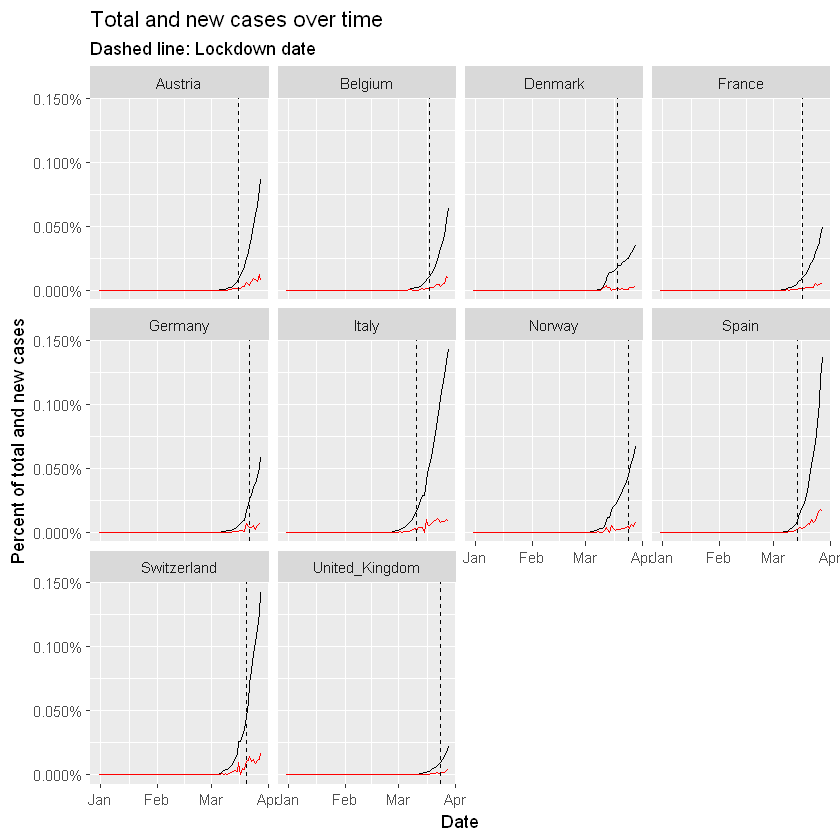

In [12]:
COVID_19_processed %>% 
    inner_join(restriction_dates %>% filter(restriction_type == "lockdown"), 
               by = "Country") %>%
    ggplot() +
        geom_line(aes(date, total_cases/population)) +
        geom_line(aes(date, new_cases/population), color = "red") +
        geom_vline(aes(xintercept = restriction_date), lty = 2) +
        facet_wrap(~Country) +
        scale_y_continuous(labels = scales::percent_format()) +
        labs(x = "Date", 
             y = "Percent of total and new cases", 
             title = "Total and new cases over time", 
             subtitle = "Dashed line: Lockdown date")

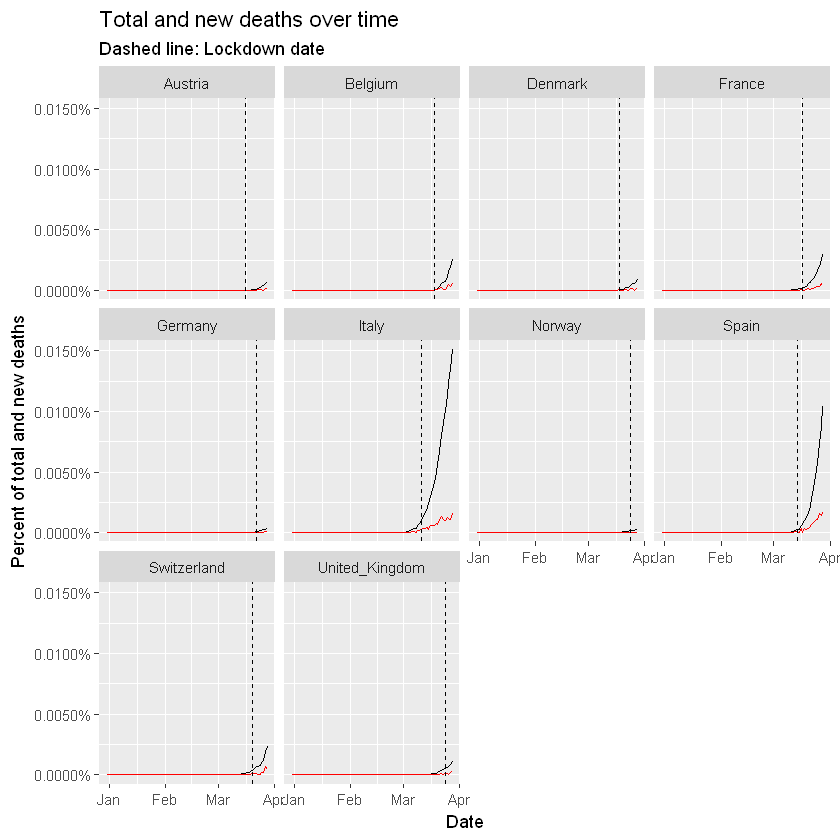

In [13]:
COVID_19_processed %>% 
    inner_join(restriction_dates %>% filter(restriction_type == "lockdown"), 
               by = "Country") %>%
    ggplot() +
        geom_line(aes(date, total_deaths/population)) +
        geom_line(aes(date, new_deaths/population), color = "red") +
        geom_vline(aes(xintercept = restriction_date), lty = 2) +
        facet_wrap(~Country) +
        scale_y_continuous(labels = scales::percent_format()) +
        labs(x = "Date", 
             y = "Percent of total and new deaths", 
             title = "Total and new deaths over time", 
             subtitle = "Dashed line: Lockdown date")

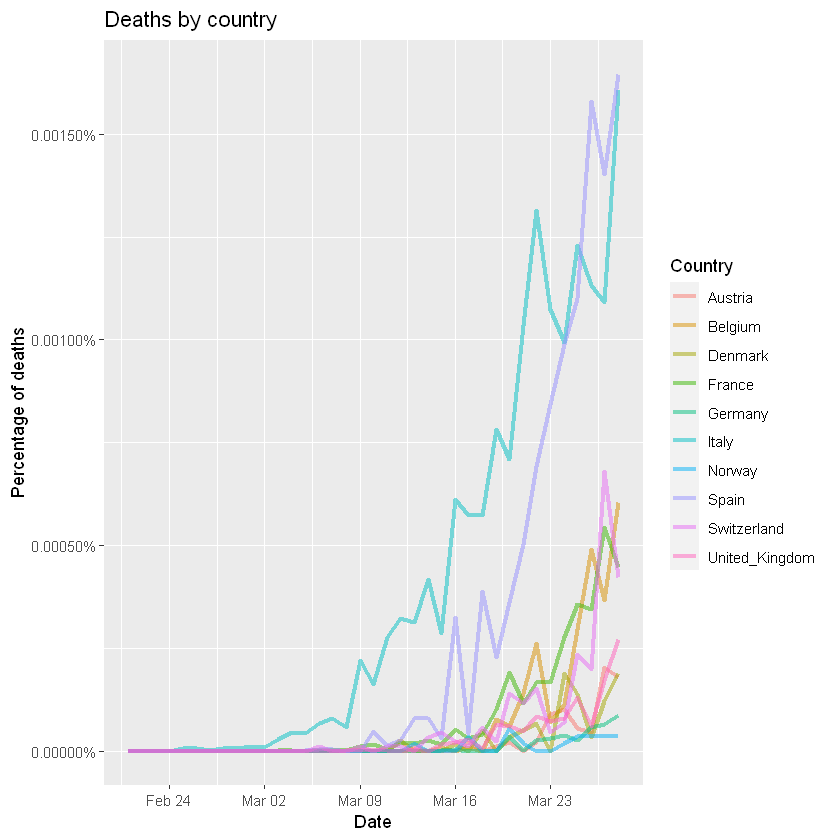

In [14]:
COVID_19_processed %>% 
    mutate(percent_cases = new_cases/population, 
           percent_deaths = new_deaths/population) %>% 
    inner_join(restriction_dates %>% filter(restriction_type == "lockdown"), 
               by = "Country") %>%
    filter(date > as.Date("2020-02-20")) %>% 
    ggplot() +
        geom_line(aes(date, percent_deaths, color = Country), size = 1.2, alpha = 0.5) +
        scale_y_continuous(labels = scales::percent_format()) +
        labs(title = "Deaths by country", 
             x = "Date", y = "Percentage of deaths")

### Cummulative Cases and Deaths

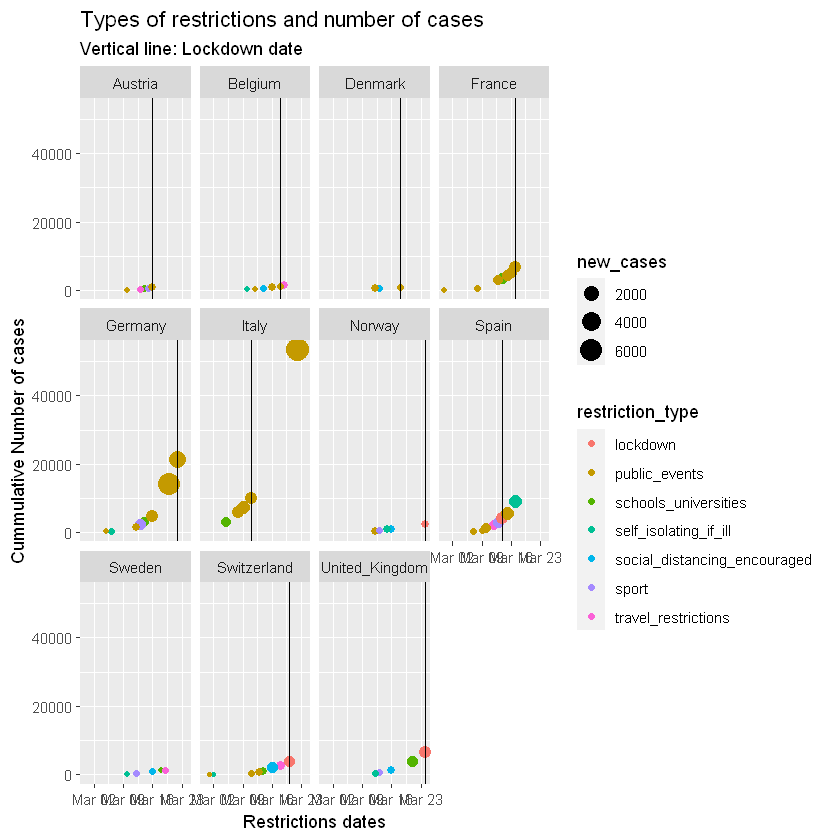

In [15]:
restriction_dates %>%
    inner_join(COVID_19_processed, by = c("Country", restriction_date = "date")) %>% 
    filter(restriction_date > as.Date("2020-02-20")) %>% 
    ggplot(aes(x = restriction_date, 
               y = total_cases, 
               color = restriction_type, 
               size = new_cases)) +
        geom_point() +
        geom_vline(aes(xintercept = restriction_date), 
                   data = restriction_dates %>% 
                               filter(restriction_type == "lockdown")) +
        facet_wrap(~Country) +
        labs(title = "Types of restrictions and number of cases", 
             subtitle = "Vertical line: Lockdown date",
             x = "Restrictions dates", y = "Cummulative Number of cases")

## Cases maps

In [113]:
iso3Codes <- maps::iso3166 %>% 
    mutate(mapname = str_remove(mapname, pattern = "\\(.*"))

world <- map_data('world') %>% 
            inner_join(iso3Codes, by  = c(region = "mapname")) %>% 
            filter(region != 'Antarctica')
COVID_maps <- 
    COVID_19_processed %>%
            mutate(Country = gsub(pattern = "_", 
                                   replacement = " ", 
                                   Country)) %>% 
            group_by(Country, date = floor_date(date, "week")) %>% 
            summarise(code = unique(code), 
                      total_cases = max(total_cases), 
                      population = max(population)) %>% 
            left_join(world, by = c(code = 'a3')) %>% 
            ungroup() %>% 
            filter(total_cases > 50)

In [114]:
#COVID_maps %>% filter(Country == "Afghanistan", date == "2020-03-01") %>% dim()
#world %>% filter(region == "Afghanistan") %>% dim()
#COVID_maps %>% distinct(date) %>% dim()

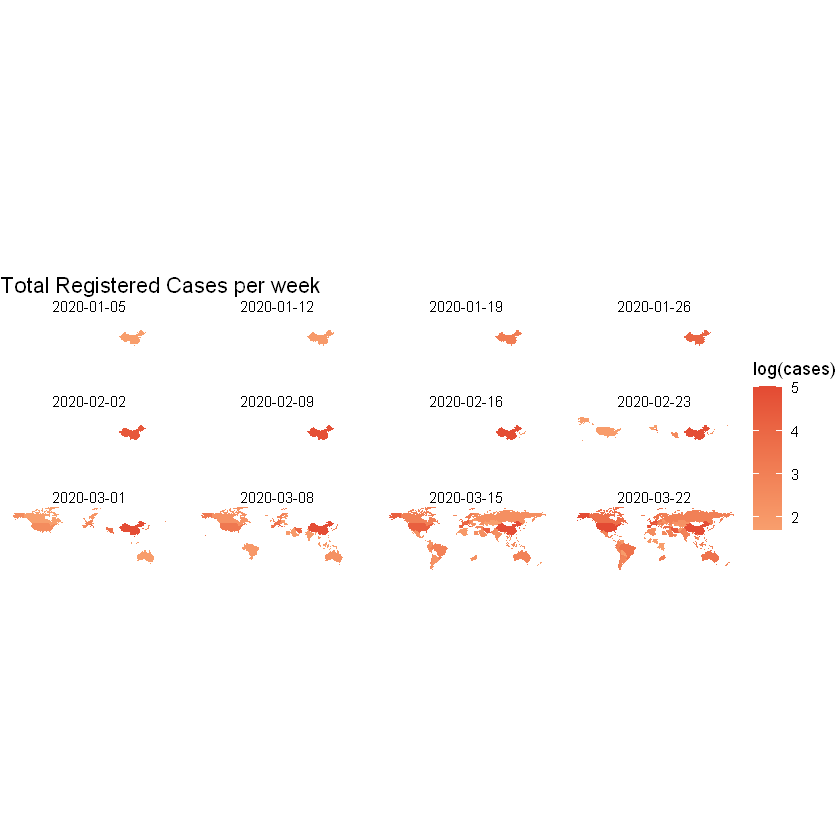

In [115]:
world_cases_week <- 
    ggplot(COVID_maps, 
           aes(long, lat, group = group, fill = log(total_cases, base = 10))) + 
        geom_polygon() +
        scale_fill_gradient2(low = '#fee8c8', 
                             mid = "#fdbb84",
                             high = '#e34a33', midpoint = 0.5) +
        facet_wrap(~date) +
        coord_quickmap() +
        labs(fill = "log(cases)", 
             title = "Total Registered Cases per week") +
        theme_void()

world_cases_week

In [116]:
ggsave(filename="world_cases_week.png", 
       plot=world_cases_week, 
       device="png", 
       dpi=500)

Saving 6.67 x 6.67 in image



# Rolling averages and days since

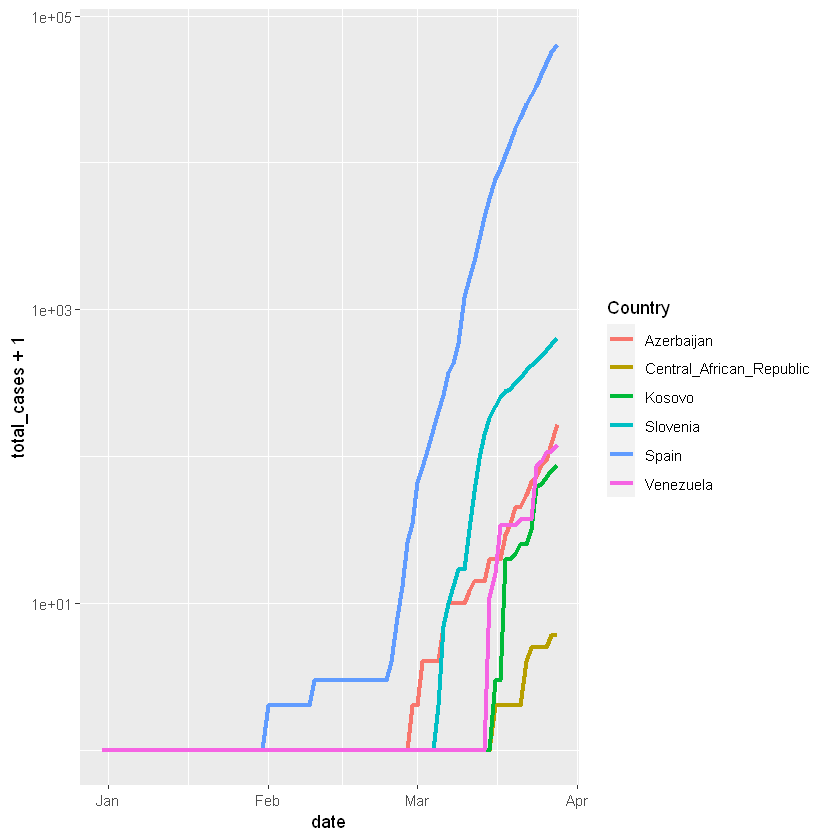

In [195]:
random_countries <- sample(unique(COVID_19_processed$Country), 6)

COVID_19_processed %>% 
        filter(Country %in% random_countries) %>% 
        ggplot(aes(date, total_cases + 1, color = Country)) +
            geom_line(size = 1.4) +
            scale_y_log10()

In [222]:
COVID_19_rolling_mean <- 
    COVID_19_processed %>% 
        group_by(Country) %>% 
        mutate(day = 1:89,
               population_millions = population / 1e6,
               cases_per_million = total_cases/population_millions,
               rolling_mean = RcppRoll::roll_mean(x = new_cases, 7, fill = NA))  %>%
        filter(cases_per_million > 0.1, 
               !is.na(rolling_mean))

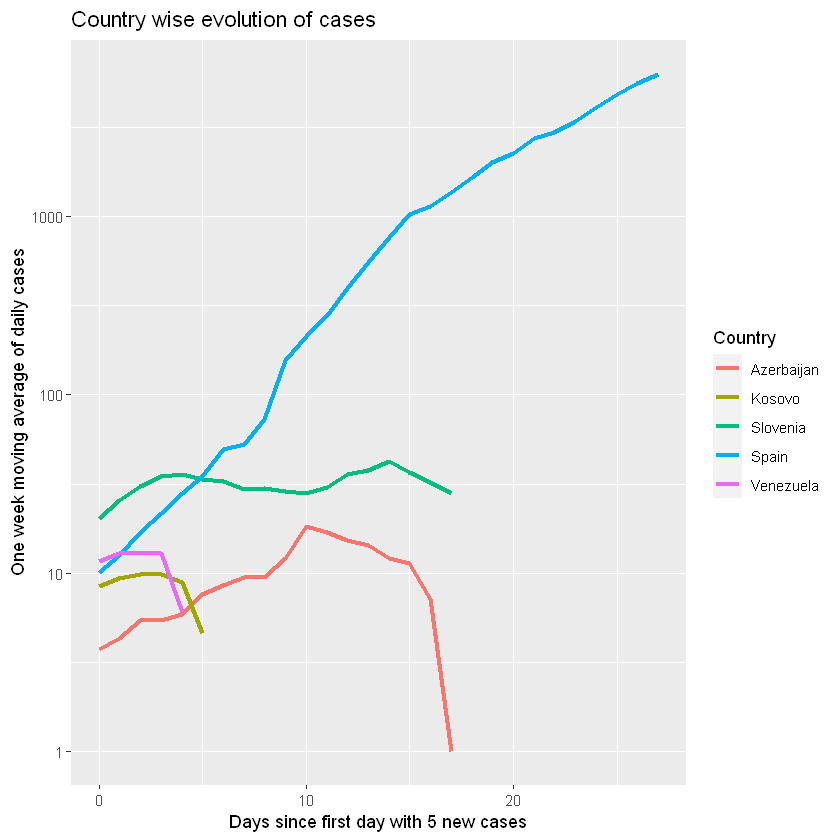

In [235]:
first_date <- COVID_19_rolling_mean %>% 
        group_by(Country) %>% 
        filter(new_cases >= 5) %>% 
        mutate(first_date = min(day)) %>%
        distinct(Country, first_date)

COVID_19_rolling_mean %>% 
        left_join(first_date, by = "Country") %>% 
        filter(!is.na(first_date), 
               day >= first_date, Country %in% random_countries) %>% 
        ggplot(aes(day - first_date, rolling_mean + 1, color = Country)) + 
            geom_line(size = 1.4) +
            scale_y_log10() +
            labs(x = "Days since first day with 5 new cases", 
                 y = "One week moving average of daily cases", 
                 title = "Country wise evolution of cases") 

## Complete Data

https://github.com/owid/covid-19-data/tree/master/public/data

In [303]:
COVID_data <- read_csv("owid-covid-data.csv")
names(COVID_data)
head(COVID_data)

Parsed with column specification:
cols(
  .default = col_double(),
  iso_code = col_character(),
  location = col_character(),
  date = col_date(format = ""),
  tests_units = col_character()
)

See spec(...) for full column specifications.



[1] "iso_code"                 "location"                
 [3] "date"                     "total_cases"             
 [5] "new_cases"                "total_deaths"            
 [7] "new_deaths"               "total_cases_per_million" 
 [9] "new_cases_per_million"    "total_deaths_per_million"
[11] "new_deaths_per_million"   "total_tests"             
[13] "new_tests"                "total_tests_per_thousand"
[15] "new_tests_per_thousand"   "tests_units"             
[17] "population"               "population_density"      
[19] "median_age"               "aged_65_older"           
[21] "aged_70_older"            "gdp_per_capita"          
[23] "extreme_poverty"          "cvd_death_rate"          
[25] "diabetes_prevalence"      "female_smokers"          
[27] "male_smokers"             "handwashing_facilities"  
[29] "hospital_beds_per_100k"

iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0,...,13.085,7.452,35973.78,NA,NA,11.62,NA,NA,NA,NA
ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0,...,13.085,7.452,35973.78,NA,NA,11.62,NA,NA,NA,NA
ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0,...,13.085,7.452,35973.78,NA,NA,11.62,NA,NA,NA,NA
ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0,...,13.085,7.452,35973.78,NA,NA,11.62,NA,NA,NA,NA
ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0,...,13.085,7.452,35973.78,NA,NA,11.62,NA,NA,NA,NA
ABW,Aruba,2020-03-27,28,9,0,0,262.256,84.296,0,...,13.085,7.452,35973.78,NA,NA,11.62,NA,NA,NA,NA


In [359]:
days_since_5 <- COVID_data %>% 
    select(location, date, total_cases, new_cases) %>% 
    filter(total_cases >= 5) %>% 
    group_by(location) %>% 
    mutate(n = n(), 
           days_since_5 = 1:n, 
           rolling_mean = RcppRoll::roll_mean(x = new_cases, 7, fill = NA)) 

Warning message in 1:n:
"numerical expression has 63 elements: only the first used"
Warning message in 1:n:
"numerical expression has 67 elements: only the first used"
Warning message in 1:n:
"numerical expression has 69 elements: only the first used"
Warning message in 1:n:
"numerical expression has 61 elements: only the first used"
Warning message in 1:n:
"numerical expression has 47 elements: only the first used"
Warning message in 1:n:
"numerical expression has 50 elements: only the first used"
Warning message in 1:n:
"numerical expression has 68 elements: only the first used"
Warning message in 1:n:
"numerical expression has 64 elements: only the first used"
Warning message in 1:n:
"numerical expression has 52 elements: only the first used"
Warning message in 1:n:
"numerical expression has 107 elements: only the first used"
Warning message in 1:n:
"numerical expression has 78 elements: only the first used"
Warning message in 1:n:
"numerical expression has 67 elements: only the fir

Warning message in 1:n:
"numerical expression has 108 elements: only the first used"
Warning message in 1:n:
"numerical expression has 57 elements: only the first used"
Warning message in 1:n:
"numerical expression has 61 elements: only the first used"
Warning message in 1:n:
"numerical expression has 62 elements: only the first used"
Warning message in 1:n:
"numerical expression has 58 elements: only the first used"
Warning message in 1:n:
"numerical expression has 59 elements: only the first used"
Warning message in 1:n:
"numerical expression has 78 elements: only the first used"
Warning message in 1:n:
"numerical expression has 57 elements: only the first used"
Warning message in 1:n:
"numerical expression has 50 elements: only the first used"
Warning message in 1:n:
"numerical expression has 67 elements: only the first used"
Warning message in 1:n:
"numerical expression has 71 elements: only the first used"
Warning message in 1:n:
"numerical expression has 44 elements: only the fir

Warning message in 1:n:
"numerical expression has 95 elements: only the first used"
Warning message in 1:n:
"numerical expression has 110 elements: only the first used"
Warning message in 1:n:
"numerical expression has 52 elements: only the first used"
Warning message in 1:n:
"numerical expression has 62 elements: only the first used"
Warning message in 1:n:
"numerical expression has 61 elements: only the first used"
Warning message in 1:n:
"numerical expression has 50 elements: only the first used"
Warning message in 1:n:
"numerical expression has 62 elements: only the first used"
Warning message in 1:n:
"numerical expression has 102 elements: only the first used"
Warning message in 1:n:
"numerical expression has 20 elements: only the first used"
Warning message in 1:n:
"numerical expression has 137 elements: only the first used"
Warning message in 1:n:
"numerical expression has 16 elements: only the first used"
Warning message in 1:n:
"numerical expression has 51 elements: only the f

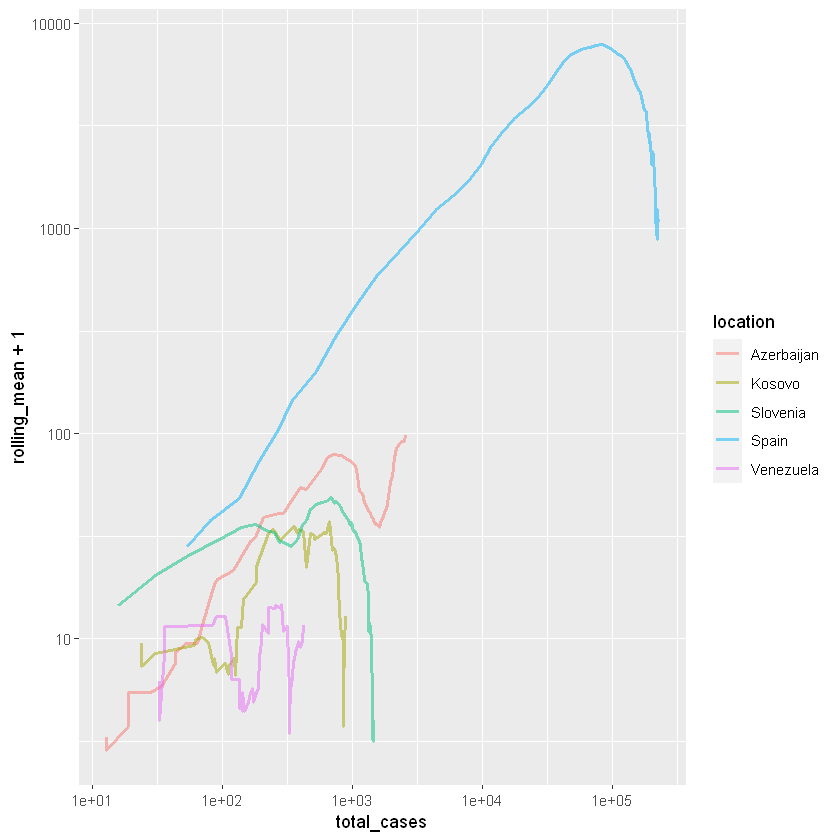

In [360]:
days_since_5 %>% 
    filter(location %in% random_countries, 
           !is.na(rolling_mean)) %>% 
    ggplot(aes(x = total_cases, y = rolling_mean + 1, color = location)) +
        geom_line(size = 1, alpha = 0.5) +
        scale_x_log10() +
        scale_y_log10()
    